[*********************100%%**********************]  1 of 1 completed


Model accuracy: 0.53
Total Return: 0.19%
Sharpe Ratio: 8.22
Max Drawdown: 3.35%


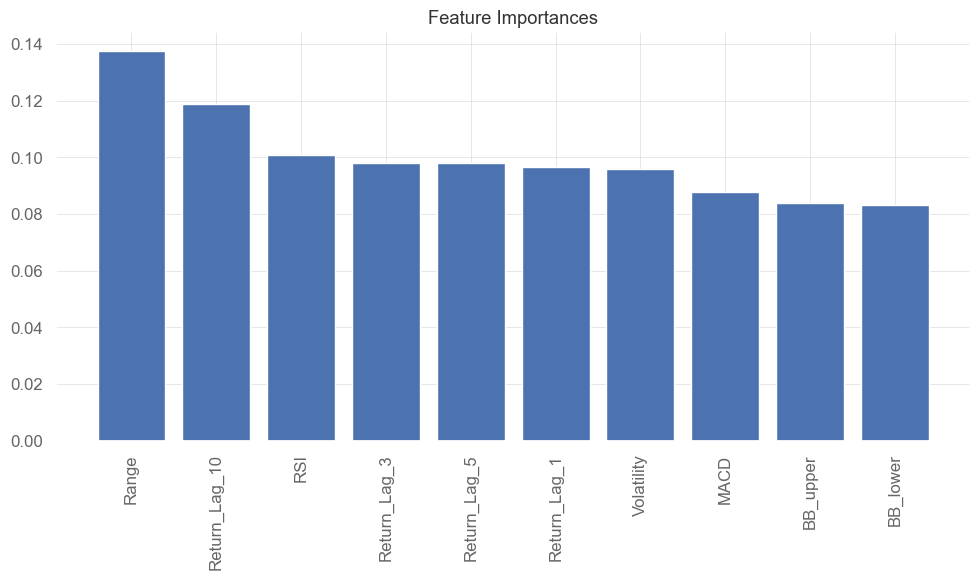

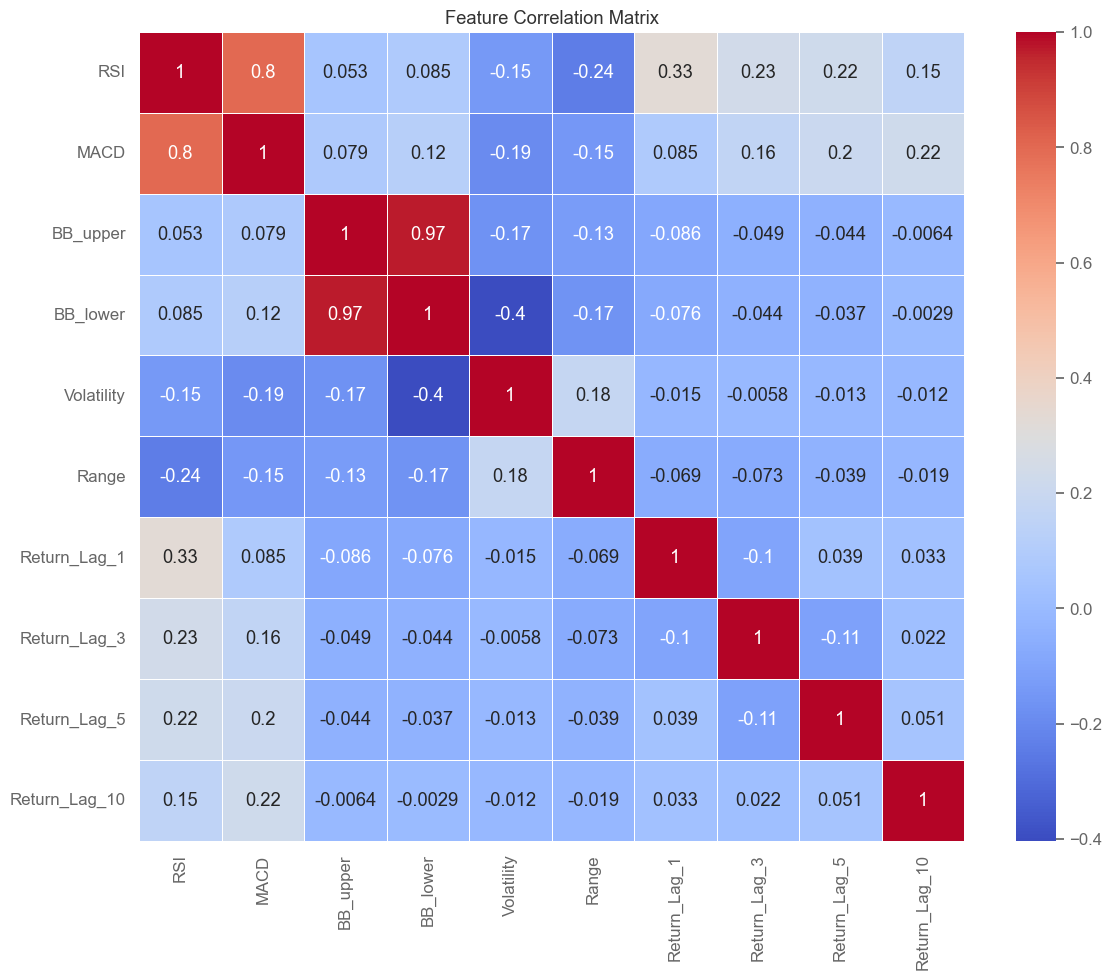

In [11]:
import pandas as pd
import numpy as np
import yfinance as yf
import ta
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

class AdvancedForexTrader:
    def __init__(self, symbol, start_date, end_date, initial_balance=1000000):
        self.symbol = symbol
        self.start_date = start_date
        self.end_date = end_date
        self.initial_balance = initial_balance
        self.data = None
        self.model = None
        self.scaler = StandardScaler()
        
    def fetch_data(self):
        self.data = yf.download(self.symbol, start=self.start_date, end=self.end_date)
        
    def engineer_features(self):
        # Technical indicators
        self.data['RSI'] = ta.momentum.RSIIndicator(self.data['Close']).rsi()
        self.data['MACD'] = ta.trend.MACD(self.data['Close']).macd()
        self.data['BB_upper'], self.data['BB_middle'], self.data['BB_lower'] = ta.volatility.BollingerBands(self.data['Close']).bollinger_hband(), ta.volatility.BollingerBands(self.data['Close']).bollinger_mavg(), ta.volatility.BollingerBands(self.data['Close']).bollinger_lband()
        
        # Custom features
        self.data['Price_Change'] = self.data['Close'].pct_change()
        self.data['Volatility'] = self.data['Close'].rolling(window=20).std()
        self.data['Range'] = self.data['High'] - self.data['Low']
        
        # Lagged features
        for lag in [1, 3, 5, 10]:
            self.data[f'Return_Lag_{lag}'] = self.data['Price_Change'].shift(lag)
        
        self.data.dropna(inplace=True)
        
    def prepare_data(self):
        features = ['RSI', 'MACD', 'BB_upper', 'BB_lower', 'Volatility', 'Range'] + [f'Return_Lag_{lag}' for lag in [1, 3, 5, 10]]
        X = self.data[features]
        y = np.where(self.data['Close'].shift(-1) > self.data['Close'], 1, 0)
        
        X_scaled = self.scaler.fit_transform(X)
        return train_test_split(X_scaled, y, test_size=0.2, random_state=42)
        
    def train_model(self):
        X_train, X_test, y_train, y_test = self.prepare_data()
        self.model = RandomForestClassifier(n_estimators=100, random_state=42)
        self.model.fit(X_train, y_train)
        print(f"Model accuracy: {self.model.score(X_test, y_test):.2f}")
        
    def generate_signals(self):
        features = ['RSI', 'MACD', 'BB_upper', 'BB_lower', 'Volatility', 'Range'] + [f'Return_Lag_{lag}' for lag in [1, 3, 5, 10]]
        X = self.data[features]
        X_scaled = self.scaler.transform(X)
        self.data['Signal'] = self.model.predict(X_scaled)
        
    def backtest(self):
        self.data['Position'] = self.data['Signal'].shift(1)
        self.data['Returns'] = self.data['Close'].pct_change()
        self.data['Strategy_Returns'] = self.data['Position'] * self.data['Returns']
        return self.data['Strategy_Returns']
        
    def plot_feature_importance(self):
        features = ['RSI', 'MACD', 'BB_upper', 'BB_lower', 'Volatility', 'Range'] + [f'Return_Lag_{lag}' for lag in [1, 3, 5, 10]]
        importances = self.model.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        plt.figure(figsize=(10, 6))
        plt.title("Feature Importances")
        plt.bar(range(len(importances)), importances[indices])
        plt.xticks(range(len(importances)), [features[i] for i in indices], rotation=90)
        plt.tight_layout()
        plt.savefig('feature_importances.png')
        
    def plot_correlation_matrix(self):
        features = ['RSI', 'MACD', 'BB_upper', 'BB_lower', 'Volatility', 'Range'] + [f'Return_Lag_{lag}' for lag in [1, 3, 5, 10]]
        corr_matrix = self.data[features].corr()
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
        plt.title("Feature Correlation Matrix")
        plt.tight_layout()
        plt.savefig('correlation_matrix.png')
        
    def expected_return(self, returns, aggregate=None, compounded=True):
        if aggregate:
            returns = returns.resample(aggregate).agg(
                lambda x: (np.prod(1 + x) - 1) if compounded else x.sum()
            )
        return np.prod(1 + returns) ** (1 / len(returns)) - 1

    def run(self):
        self.fetch_data()
        self.engineer_features()
        self.train_model()
        self.generate_signals()
        strategy_returns = self.backtest()
        self.plot_feature_importance()
        self.plot_correlation_matrix()
        
        # Calculate metrics manually
        total_return = self.expected_return(strategy_returns)
        sharpe_ratio = np.sqrt(252) * strategy_returns.mean() / strategy_returns.std()
        max_drawdown = (strategy_returns.cummax() - strategy_returns).max()
        
        print(f"Total Return: {total_return:.2%}")
        print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
        print(f"Max Drawdown: {max_drawdown:.2%}")
        
        # Generate a simple HTML report
        report = f"""
        <html>
        <head><title>USD/JPY Trading Strategy Report</title></head>
        <body>
        <h1>USD/JPY Trading Strategy Report</h1>
        <p>Total Return: {total_return:.2%}</p>
        <p>Sharpe Ratio: {sharpe_ratio:.2f}</p>
        <p>Max Drawdown: {max_drawdown:.2%}</p>
        <img src="feature_importances.png" alt="Feature Importances">
        <img src="correlation_matrix.png" alt="Correlation Matrix">
        </body>
        </html>
        """
        
        with open('usd_jpy_quant_report.html', 'w') as f:
            f.write(report)

if __name__ == "__main__":
    trader = AdvancedForexTrader("USDJPY=X", "2023-01-01", "2024-07-21")
    trader.run()